In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import ast
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_theme()
from importlib import reload
import torch

# Silencing warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import LinearRegression

In [3]:
cognates={'AGR' :  ['Agricultural Inputs', 'Farm & Heavy Construction Machinery', 'Farm Products'],
          'AUT' :  ['Auto & Truck Dealerships', 'Auto Manufacturers', 'Auto Parts', 'Recreational Vehicles'],
          'BEV' :  ['Beverages - Brewers', 'Beverages - Non-Alcoholic', 'Beverages - Wineries & Distilleries'], 
          'CHM' :  ['Chemicals', 'Specialty Chemicals'], 
          'DEF' :  ['Aerospace & Defense'], #Here I deviate from Paul's choice to include `AER` here as well
          'EDU' :  ['Education & Training Services'],
          'ENG' :  ['Solar'], #`ENG` code does not cover oil and gas, although many oil and gas companies lobby this code.
          'FOO' :  ['Confectioners', 'Food Distribution', 'Packaged Foods'],
          'FUE' :  ['Oil & Gas Drilling', 'Oil & Gas E&P','Oil & Gas Equipment & Services', 'Oil & Gas Integrated', 'Oil & Gas Midstream', 'Oil & Gas Refining & Marketing'],
          'INS' :  ['Insurance - Diversified', 'Insurance - Life', 'Insurance - Property & Casualty', 'Insurance - Reinsurance', 'Insurance - Specialty', 'Insurance Brokers'],
          'MAN' :  ['Metal Fabrication', 'Specialty Industrial Machinery', 'Steel', 'Textile Manufacturing'], #I added to this one to match choices Paul made
          'NAT' :  ['Aluminum', 'Copper', 'Lumber & Wood Production', 'Other Industrial Metals & Mining', 'Other Precious Metals & Mining', 'Silver'],
          'PHA' :  ['Drug Manufacturers - General', 'Drug Manufacturers - Specialty & Generic', 'Pharmaceutical Retailers'],
          'RES' :  ['REIT - Diversified', 'REIT - Industrial', 'REIT - Mortgage', 'REIT - Office', 'REIT - Specialty', 'Real Estate - Development', 'Real Estate - Diversified', 'Real Estate Services'],
          'RRR' :  ['Railroads'],
          'TEC' :  ['Telecom Services'],
          'TOB' :  ['Tobacco'],
          'UTI' :  ['Utilities - Diversified', 'Utilities - Independent Power Producers', 'Utilities - Regulated Water', 'Utilities - Renewable'] }

In [8]:
import scripts.data_extraction
reload(scripts.data_extraction)
from scripts.data_extraction import stock_and_lobbying_totals, lobbying_totals

In [5]:
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models.forecasting.baselines import (NaiveSeasonal, NaiveDrift) #used in baseline model
from darts.models import (VARIMA, XGBModel, NBEATSModel)
VARIMA.min_train_series_length=15 #This removes the restriction that VARIMA needs 30 data points to fit.
from darts.metrics import (mae, #metrics for model performance
                           mse, 
                           mase, 
                           msse)
from darts.dataprocessing.transformers import Scaler #DARTS has a preprocessing function like sklearn's StandardScaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import logging

logging.disable(logging.CRITICAL)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }


The StatsForecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


## Performance on the test set

Recall that we have reserved the last year of data (2023) as our test set. It's time to see how our models performed!

#### Baseline

In [29]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [6]:
def predict_baseline(issue_code, predict_from=pd.to_datetime("2022-01-01", format="%Y-%m-%d"), prediction_length=4): #predict from is the first date to be predicted
    df=stock_and_lobbying_totals(issue_code, cognates[issue_code], adjust_for_num_codes=True, train_only=False)
    df['log_gross']=np.log1p(df.stocks_gross)
    df=df[df.index  < pd.to_datetime("2024-01-01", format="%Y-%m-%d")] #fixing inconsistencies in the data
    df=df[df.index >= pd.to_datetime("2014-01-01", format="%Y-%m-%d")] #
    df_train=df[df.index< predict_from]
    ts=TimeSeries.from_dataframe(df)
    ts_train=TimeSeries.from_dataframe(df_train)
    expenses_model= NaiveSeasonal(K=4)
    expenses_model.fit(ts_train['lobbying_expenses'])
    income_model=NaiveDrift()
    income_model.fit(ts_train['lobbying_income'])
    expenses_pred=expenses_model.predict(n=prediction_length)
    income_pred=income_model.predict(n=prediction_length)
    linear=LinearRegression()
    linear.fit(X=df_train.index.values.reshape(-1,1), y=df_train['log_gross'].values.reshape(-1,1))
    pred_range= np.arange(predict_from, predict_from+prediction_length(timedelta(month=3)), timedelta(month=3)).astype(datetime)
    linear_df=linear.predict(X=pred_range)
    lobbying_pred=expenses_pred+income_pred
    stocks_pred=Timeseries.from_series(np.expm1(linear_df))
    pred=stocks_pred.stack(lobbying_pred)
    return pred, ts['lobbying_total','stocks_gross']

In [28]:
def predict(issue_code, model, lobb_vars=['lobbying_total'], stocks_vars=['stocks_gross'], use_log_stocks=False):
    if isinstance(lobb_vars, str):
        lobb_vars = [lobb_vars]
    if isinstance(stocks_vars, str):
        stocks_vars = [stocks_vars]
    df=stock_and_lobbying_totals(issue_code, cognates[issue_code], train_only=False)[lobb_vars+stocks_vars] #changed to cover the train-test split.
    df=df[df.index  < pd.to_datetime("2024-01-01", format="%Y-%m-%d")]
    df=df[df.index >= pd.to_datetime("2014-01-01", format="%Y-%m-%d")]
    if use_log_stocks==True:
        for stocks_var in stocks_vars:
            df['log_'+stocks_var]=np.log1p(df[stocks_var])
        log_stocks_vars=['log_'+stocks_var for stocks_var in stocks_vars]
        totals_df=df[lobb_vars+log_stocks_vars]
    else:
        totals_df=df
    totals=TimeSeries.from_dataframe(totals_df)
    scaler=Scaler()
    totals_scaled =scaler.fit_transform(totals)
    train_scaled=totals_scaled[:-4]
    val_scaled=totals_scaled[-4:]
    scaled_pred = fit_and_pred(model, train_scaled, val_scaled)
    pred=scaler.inverse_transform(scaled_pred)
    if use_log_stocks==True:
        pred_df=pred.pd_dataframe()
        for stocks_var in stocks_vars:
            pred_df[stocks_var]=pred_df["log_"+stocks_var].apply(lambda x : np.expm1(x))
        df_final=pred_df[lobb_vars+stocks_vars]
        true_pred=TimeSeries.from_dataframe(df_final)
    else:
        true_pred=pred
    return true_pred, TimeSeries.from_dataframe(df)

In [7]:
predict_baseline('AGR')

TypeError: 'month' is an invalid keyword argument for __new__()

## Modeling lobbying independently

We settled on a Seasonal VARIMA(1, 1, 1) model for the lobbying data. This first found a quarterly pattern in the expenses data, and then fit the income and deseasonalized expenses jointly using VARIMA.

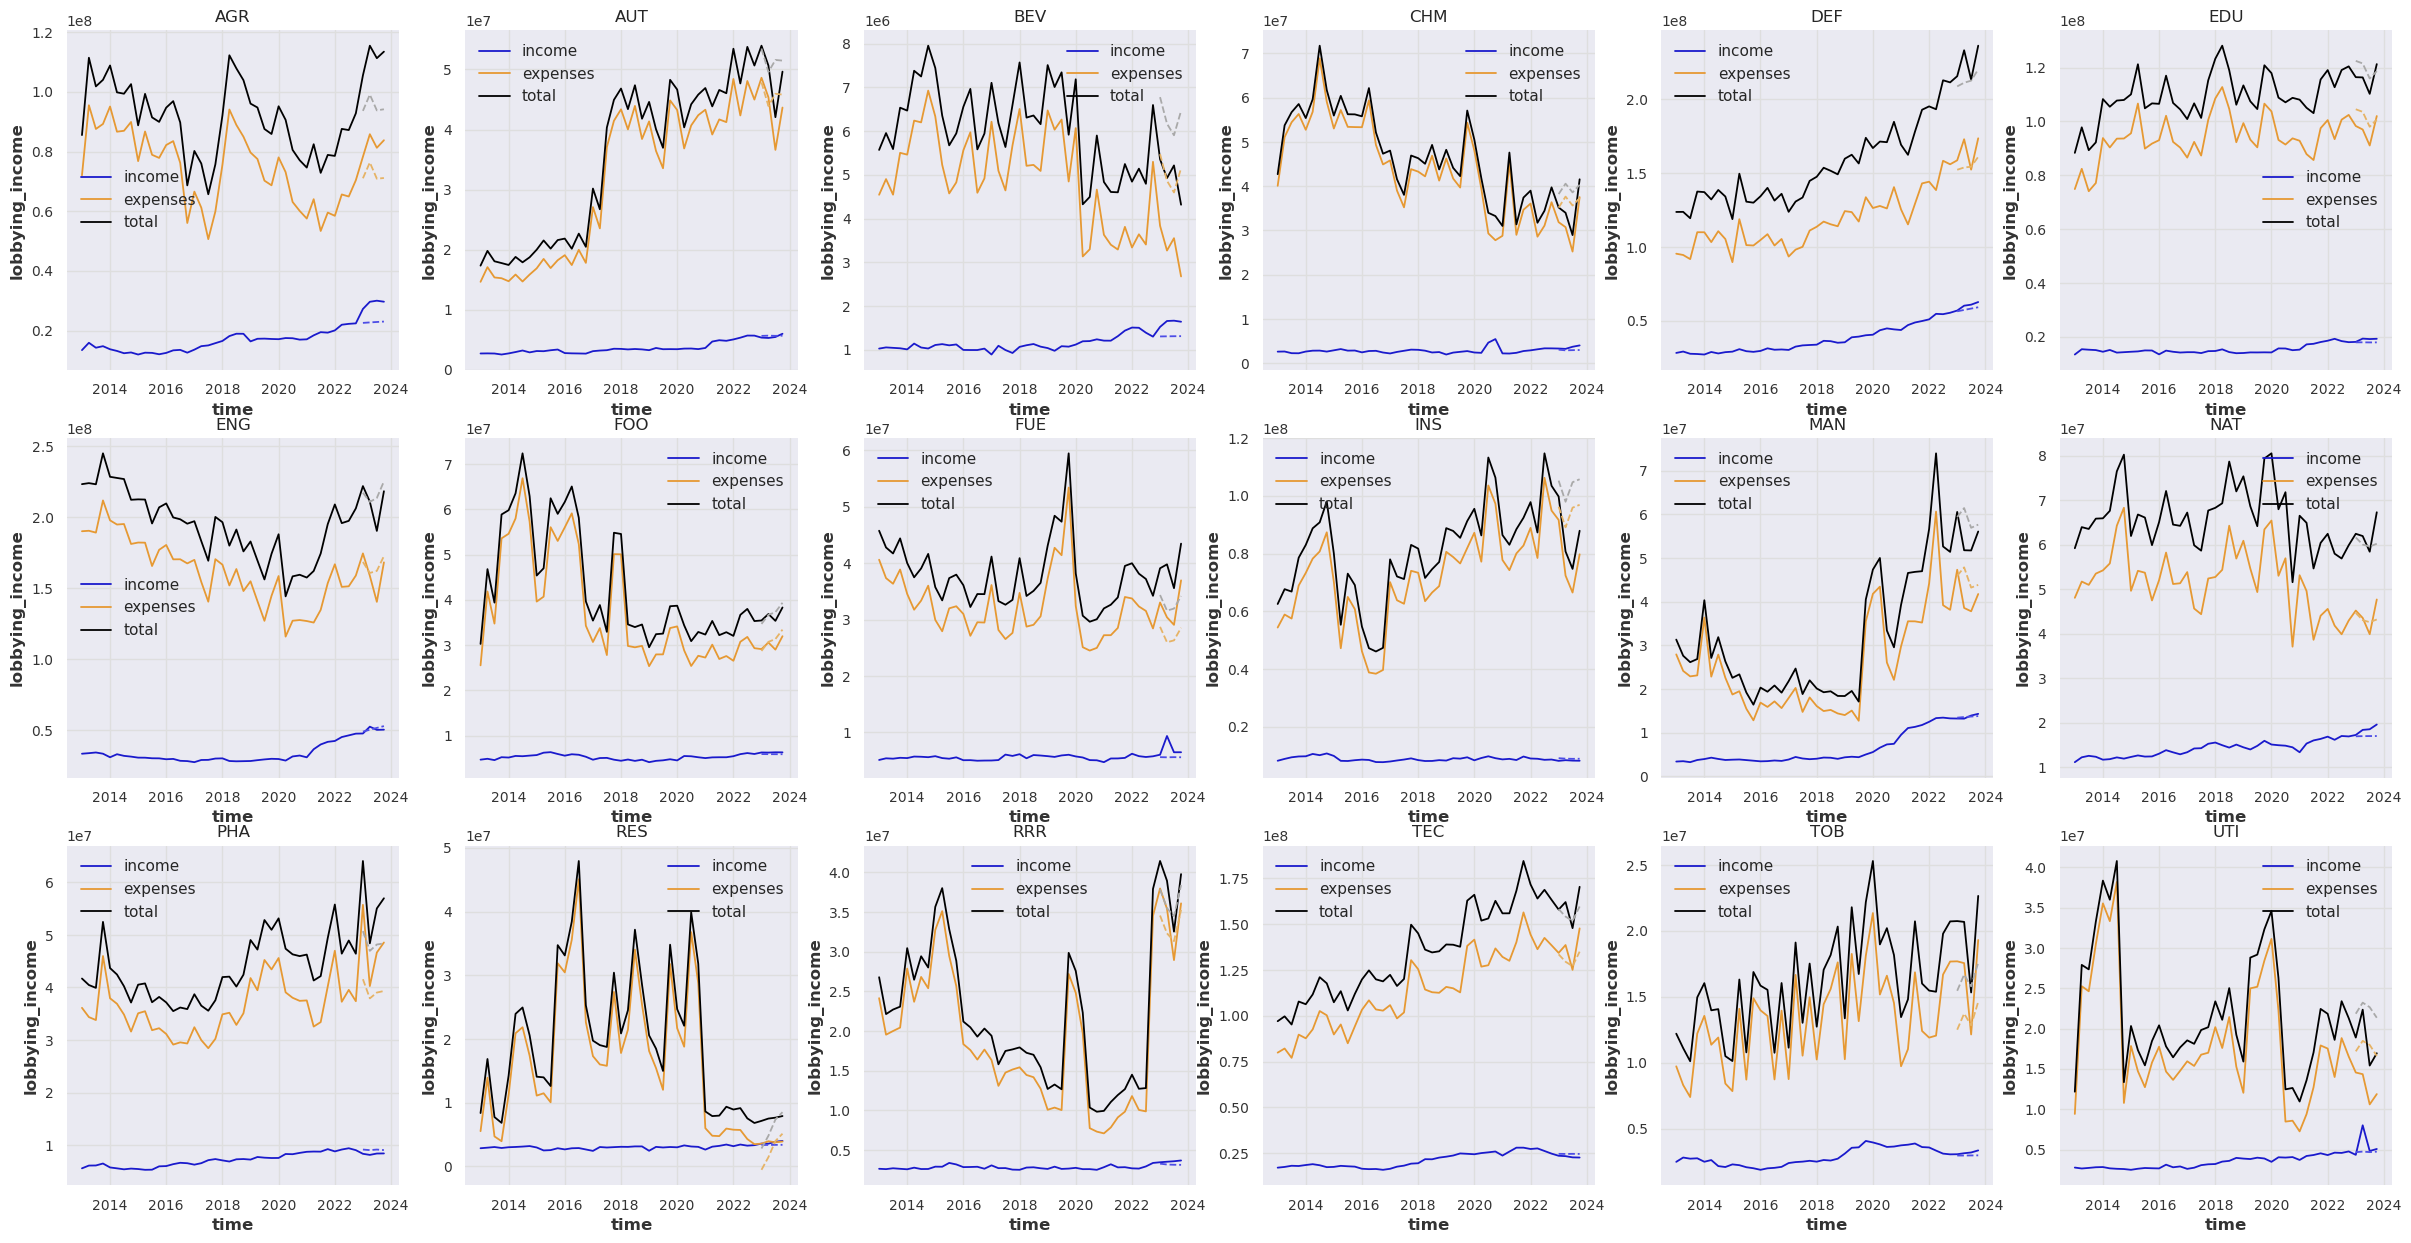

In [15]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import SeasonalityMode
from statsmodels.tools.sm_exceptions import ConvergenceWarning, EstimationWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=EstimationWarning)

fig, axs = plt.subplots(3, 6, figsize=(30, 15))
axs = axs.flatten()

scores = pd.DataFrame(columns=cognates.keys(), index=["Test MSSE"])

for i, code in enumerate(cognates.keys()):
    X_df = lobbying_totals(code, train_only=False )[["lobbying_income", "lobbying_expenses"]]
    X_df = X_df[X_df.index < pd.to_datetime("2024-01-01", format="%Y-%m-%d")]

    sns.lineplot(X_df["lobbying_income"], linestyle="solid", label="income", color=(0.1, 0.1, 0.8), ax=axs[i])
    sns.lineplot(X_df["lobbying_expenses"], linestyle="solid", label="expenses", color=(0.9, 0.6, 0.2), ax=axs[i])
    sns.lineplot(X_df.sum(axis=1), linestyle="solid", label="total", color="black", ax=axs[i])

    income_train = TimeSeries.from_series(X_df["lobbying_income"].iloc[:-4])
    income_test = TimeSeries.from_series(X_df["lobbying_income"].iloc[-4:])
    expenses_train = TimeSeries.from_series(X_df["lobbying_expenses"].iloc[:-4])
    expenses_test = TimeSeries.from_series(X_df["lobbying_expenses"].iloc[-4:])
    X_train = concatenate([income_train, expenses_train], axis=1)
    X_test = concatenate([income_test, expenses_test], axis=1)

    _, seas = extract_trend_and_seasonality(expenses_train, model=SeasonalityMode.ADDITIVE, freq=4)
    expenses_train_deseas = expenses_train - seas
    X_train_deseas = concatenate([income_train, expenses_train_deseas], axis=1)

    model = VARIMA(1, 1, 1, "n").fit(X_train_deseas)

    preds_deseas = model.predict(4)
    preds = preds_deseas + concatenate([TimeSeries.from_series(np.zeros(4)), seas[-4:]], axis=1, ignore_time_axis=True)
    MSSE = msse(X_test.sum(axis=1), preds.sum(axis=1), X_train.sum(axis=1), m=1)
    scores.loc["Test MSSE", code] = MSSE
    
    preds_df = preds.pd_dataframe().rename(columns=lambda x: x + "_preds")
    sns.lineplot(preds_df["lobbying_income_preds"], linestyle="dashed", label=None, color=(0.3, 0.3, 0.9), ax=axs[i])
    sns.lineplot(preds_df["lobbying_expenses_preds"], linestyle="dashed", label=None, color=(0.9, 0.7, 0.4), ax=axs[i])
    sns.lineplot(preds_df.sum(axis=1), linestyle="dashed", label=None, color="darkgray", ax=axs[i])

    axs[i].set_title(code)

In [13]:
scores

,AGR,AUT,BEV,CHM,DEF,EDU,ENG,FOO,FUE,INS,MAN,NAT,PHA,RES,RRR,TEC,TOB,UTI
Test MSSE,3.044355,1.182632,2.457302,0.738607,1.765091,0.419701,0.783211,0.017831,1.644515,2.709241,0.494041,0.244868,4.395408,0.073738,0.210741,0.539798,0.937196,0.444243


In [19]:
print(f"Total MSSE from modeling lobbying independently: {scores.sum(axis=1).item():.3f}")

Total MSSE from modeling lobbying independently: 22.103


## Modeling stocks independently

A baseline model is the naive drift model. Here are its predictions on the test set: 

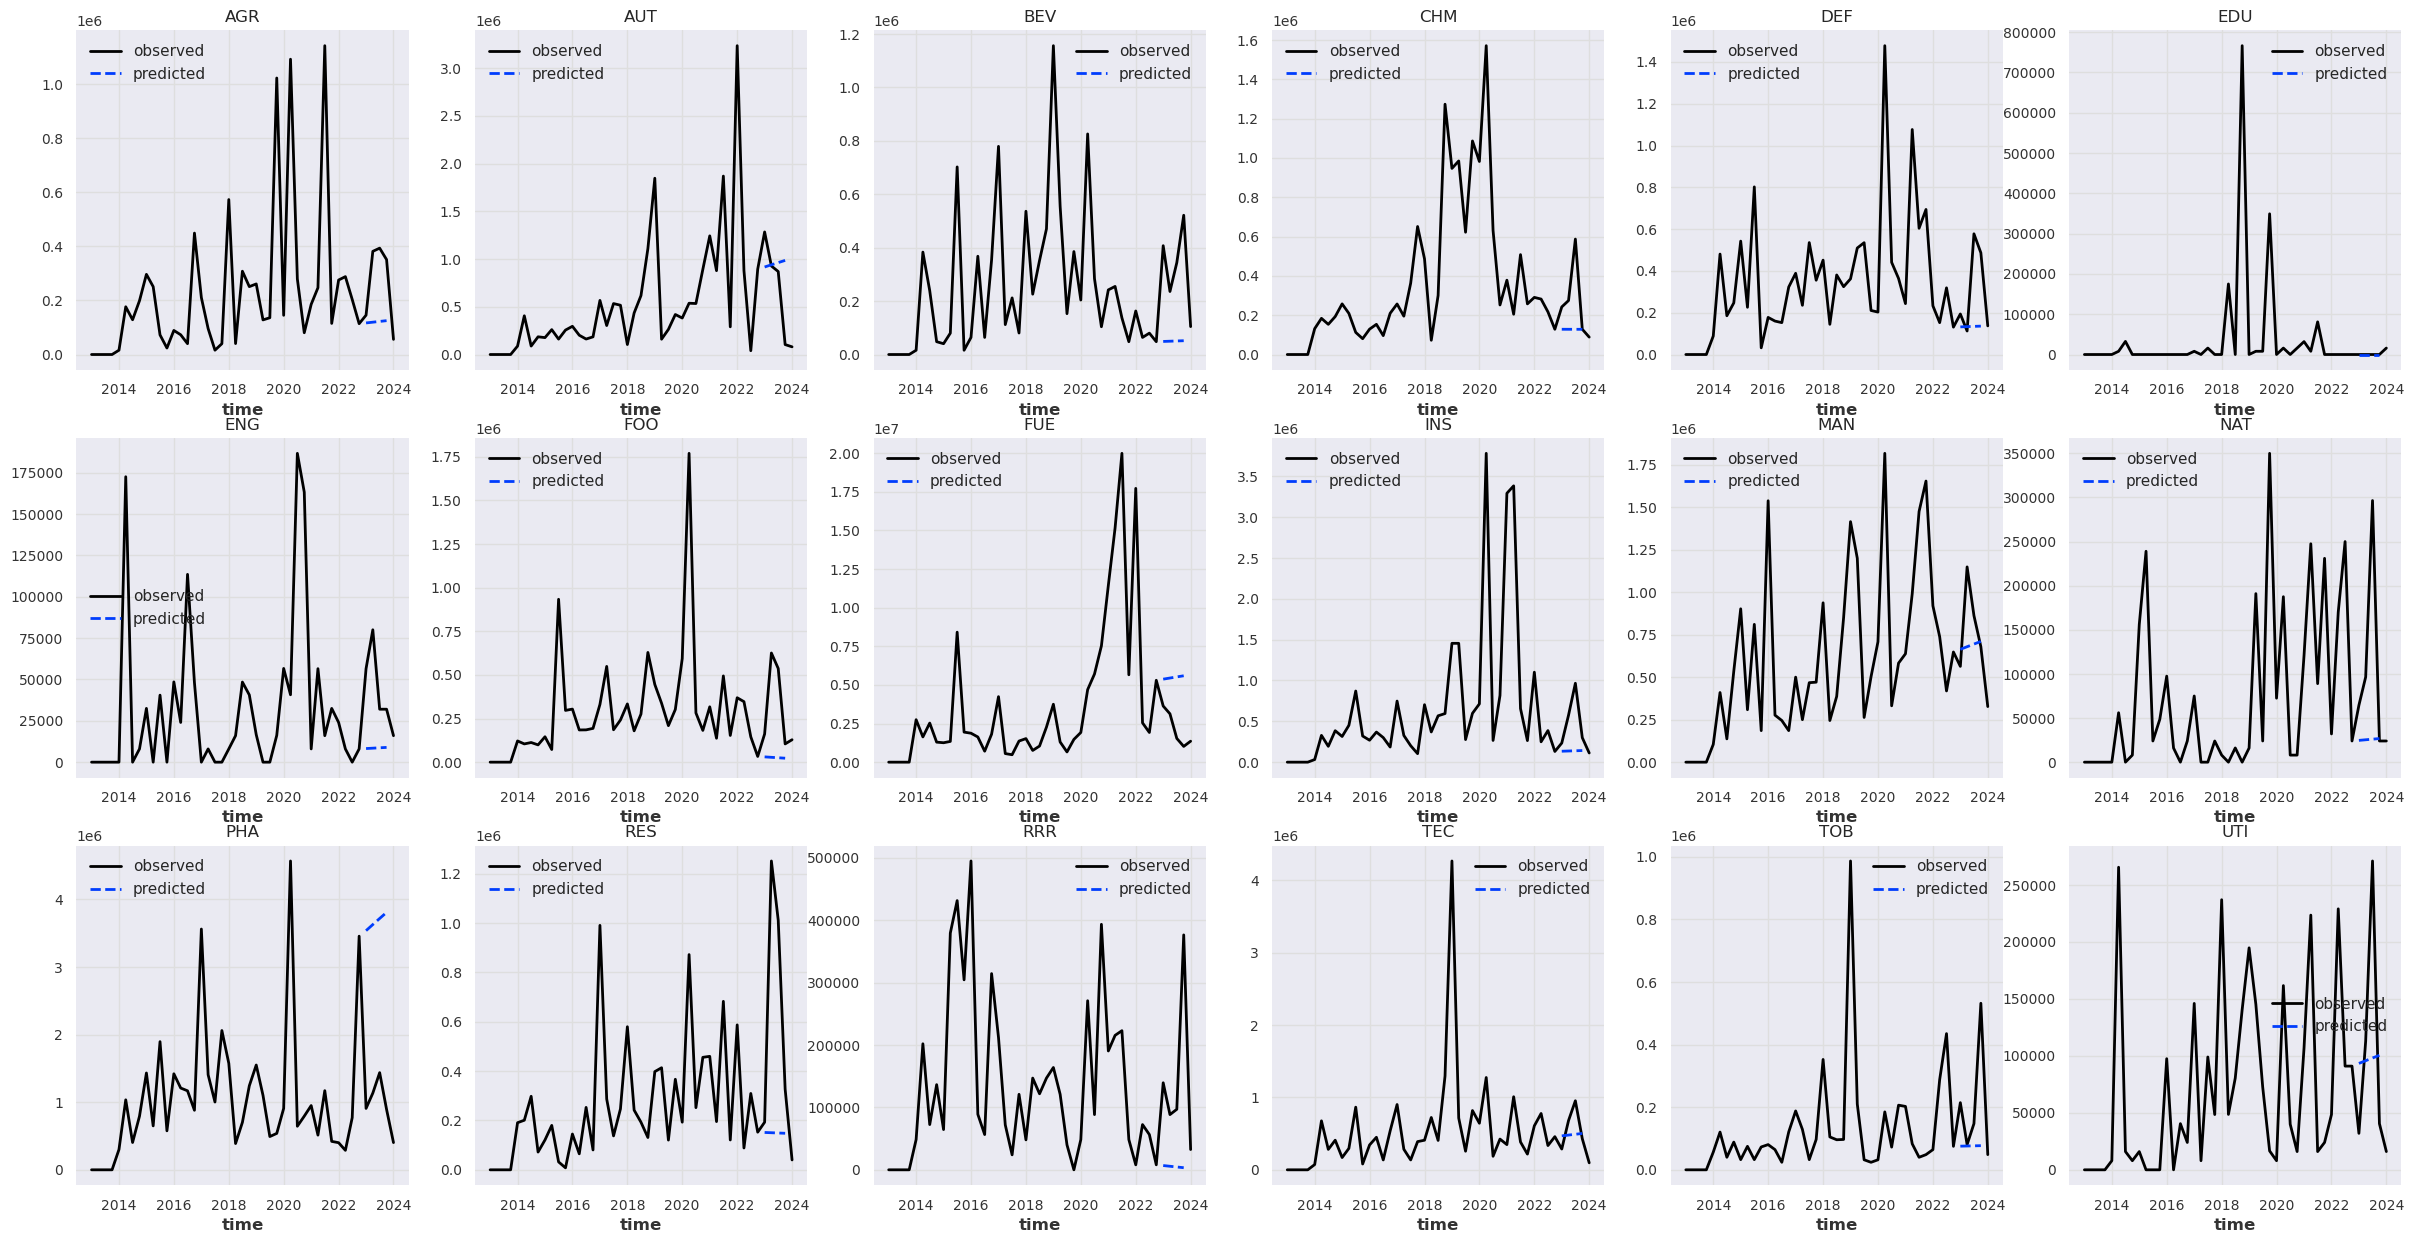

In [50]:
fig, axs = plt.subplots(3, 6, figsize=(30, 15))
axs = axs.flatten()

scores = pd.DataFrame(columns=cognates.keys(), index=["Test MSSE"])
for i, issue_code in enumerate(cognates.keys()):
    model = NaiveDrift()
    pred, _ = predict(issue_code, model, lobb_vars=[], stocks_vars=['stocks_purchase', 'stocks_sale'], use_log_stocks=False)
    pred_gross = pred.sum(axis=1)
    gross = TimeSeries.from_series(stock_totals(cognates[issue_code], train_only=False)["stocks_gross"])
    gross.plot(label="observed", ax=axs[i])
    pred_gross.plot(linestyle="dashed", label="predicted", ax=axs[i])
    axs[i].set_title(issue_code)
    scores.loc["Test MSSE", issue_code] = msse(gross[-4:], pred_gross, gross[:-4])

In [48]:
scores

,AGR,AUT,BEV,CHM,DEF,EDU,ENG,FOO,FUE,INS,MAN,NAT,PHA,RES,RRR,TEC,TOB,UTI
Test MSSE,0.41458,0.425347,1.063921,0.879883,0.718257,0.0,0.58751,1.425006,0.689447,0.283632,0.270432,1.755489,4.331386,6.298528,2.62362,0.118878,1.464514,0.997312


In [49]:
scores.sum(axis=1)

Test MSSE    24.347742
dtype: object

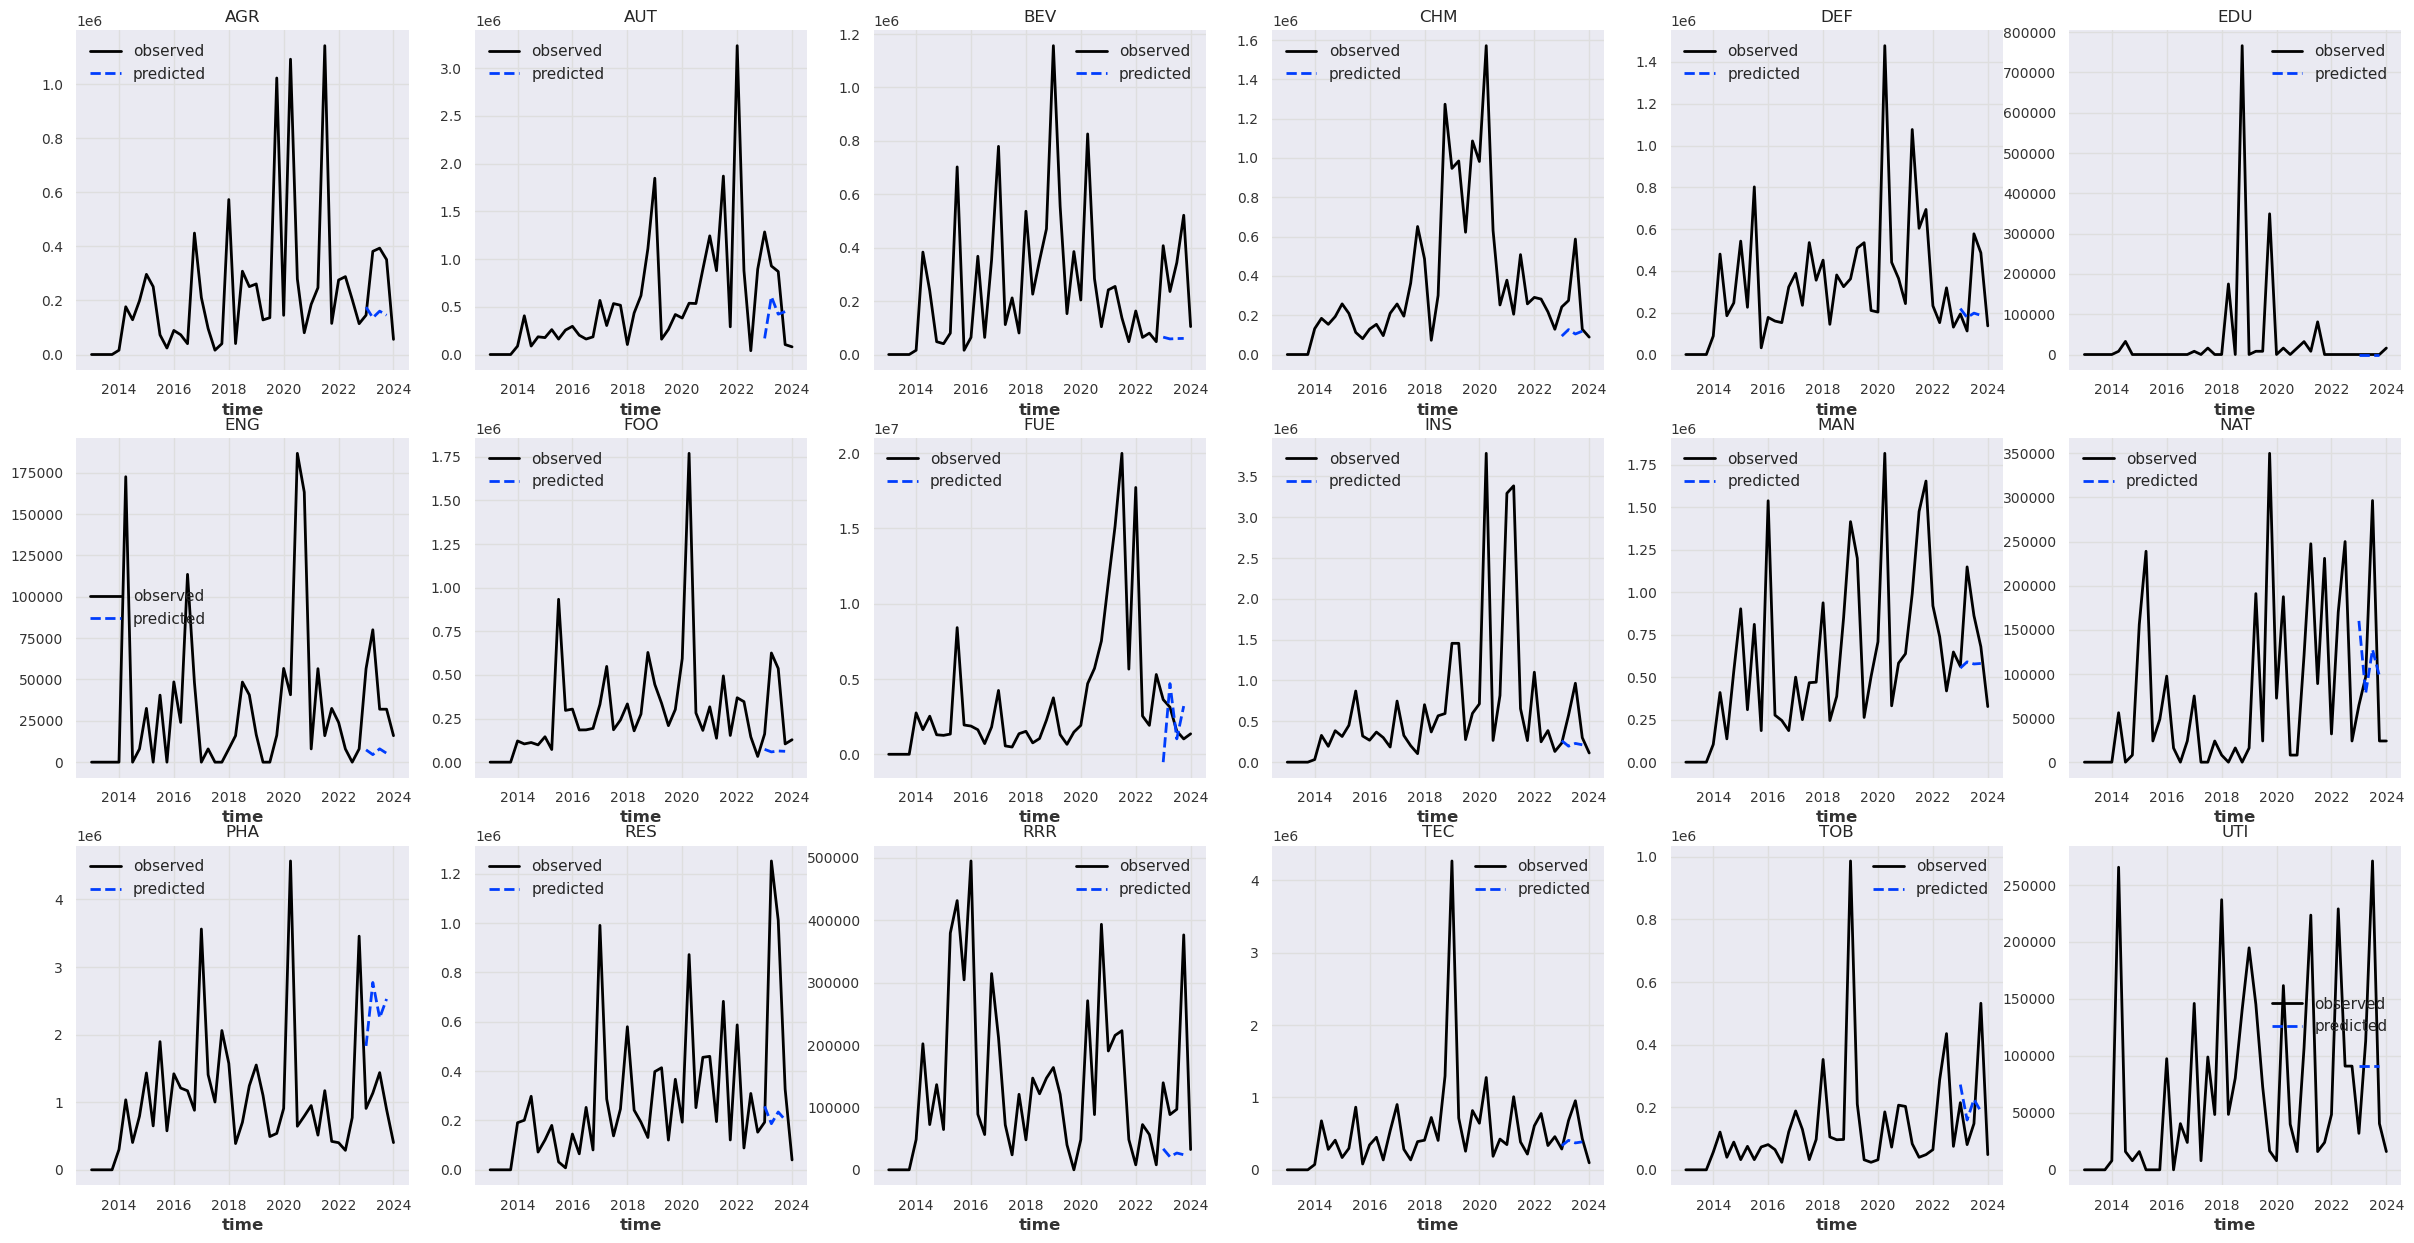

In [51]:
fig, axs = plt.subplots(3, 6, figsize=(30, 15))
axs = axs.flatten()

scores = pd.DataFrame(columns=cognates.keys(), index=["Test MSSE"])
for i, issue_code in enumerate(cognates.keys()):
    model = VARIMA(1, 1, 0)
    pred, _ = predict(issue_code, model, lobb_vars=[], stocks_vars=['stocks_purchase', 'stocks_sale'], use_log_stocks=False)
    pred_gross = pred.sum(axis=1)
    gross = TimeSeries.from_series(stock_totals(cognates[issue_code], train_only=False)["stocks_gross"])
    gross.plot(label="observed", ax=axs[i])
    pred_gross.plot(linestyle="dashed", label="predicted", ax=axs[i])
    axs[i].set_title(issue_code)
    scores.loc["Test MSSE", issue_code] = msse(gross[-4:], pred_gross, gross[:-4])

In [52]:
scores

,AGR,AUT,BEV,CHM,DEF,EDU,ENG,FOO,FUE,INS,MAN,NAT,PHA,RES,RRR,TEC,TOB,UTI
Test MSSE,0.336973,0.228056,1.012813,0.967316,0.534216,0.0,0.661479,1.244407,0.122394,0.218647,0.436453,0.769379,1.305962,5.553122,2.267476,0.190368,0.909424,1.04598


In [53]:
scores.sum(axis=1)

Test MSSE    17.804466
dtype: object

#### VARIMA model

Our winning joint model was a collection of $\mathrm{VARIMA}(1,0,q)$ models, where $q$ ranged from $0$ to $2$ and depended on the code. The input is the two component time series `['lobbying_total','stocks_gross']`.

In [15]:
joint_model_params={'AGR': [(1, 0, 1), 0.7986800761251108],
 'AUT': [(1, 0, 0), 3.929747156036474],
 'BEV': [(1, 0, 2), 0.29957140903116636],
 'CHM': [(1, 0, 1), 0.3744373201200332],
 'DEF': [(1, 0, 1), 2.5169910328413088],
 'EDU': [(1, 0, 2), 0.43747712380446596],
 'ENG': [(1, 0, 0), 0.7636785944957377],
 'FOO': [(1, 0, 2), 0.13128915094443824],
 'FUE': [(1, 0, 2), 2.6236389367195874],
 'INS': [(1, 0, 0), 1.311633160386166],
 'MAN': [(1, 0, 0), 4.106905483285991],
 'NAT': [(1, 0, 1), 0.7145649100936913],
 'PHA': [(1, 0, 2), 1.2795637339964383],
 'RES': [(1, 0, 2), 0.4584961075430376],
 'RRR': [(1, 0, 1), 2.809308927842416],
 'TEC': [(1, 0, 1), 1.5697362204545737],
 'TOB': [(1, 0, 1), 0.44832263107115833],
 'UTI': [(1, 0, 0), 0.3873363512175118]}

Let's train and predict on the test set.

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification is

,AGR,AUT,BEV,CHM,DEF,EDU,ENG,FOO,FUE,INS,MAN,NAT,PHA,RES,RRR,TEC,TOB,UTI
lobbying_total,7.194397,0.719472,0.735526,0.430531,6.057409,0.420435,1.053561,0.246712,1.662169,0.952337,1.425717,1.141522,10.470651,0.001629,1.617766,0.760461,0.465770,0.180757
stocks_gross,0.128751,0.269573,0.441997,0.361650,0.355426,0.363921,0.231429,0.309947,0.071890,0.208970,0.135351,0.947909,0.151838,5.174040,0.546391,0.163999,0.849818,1.048501


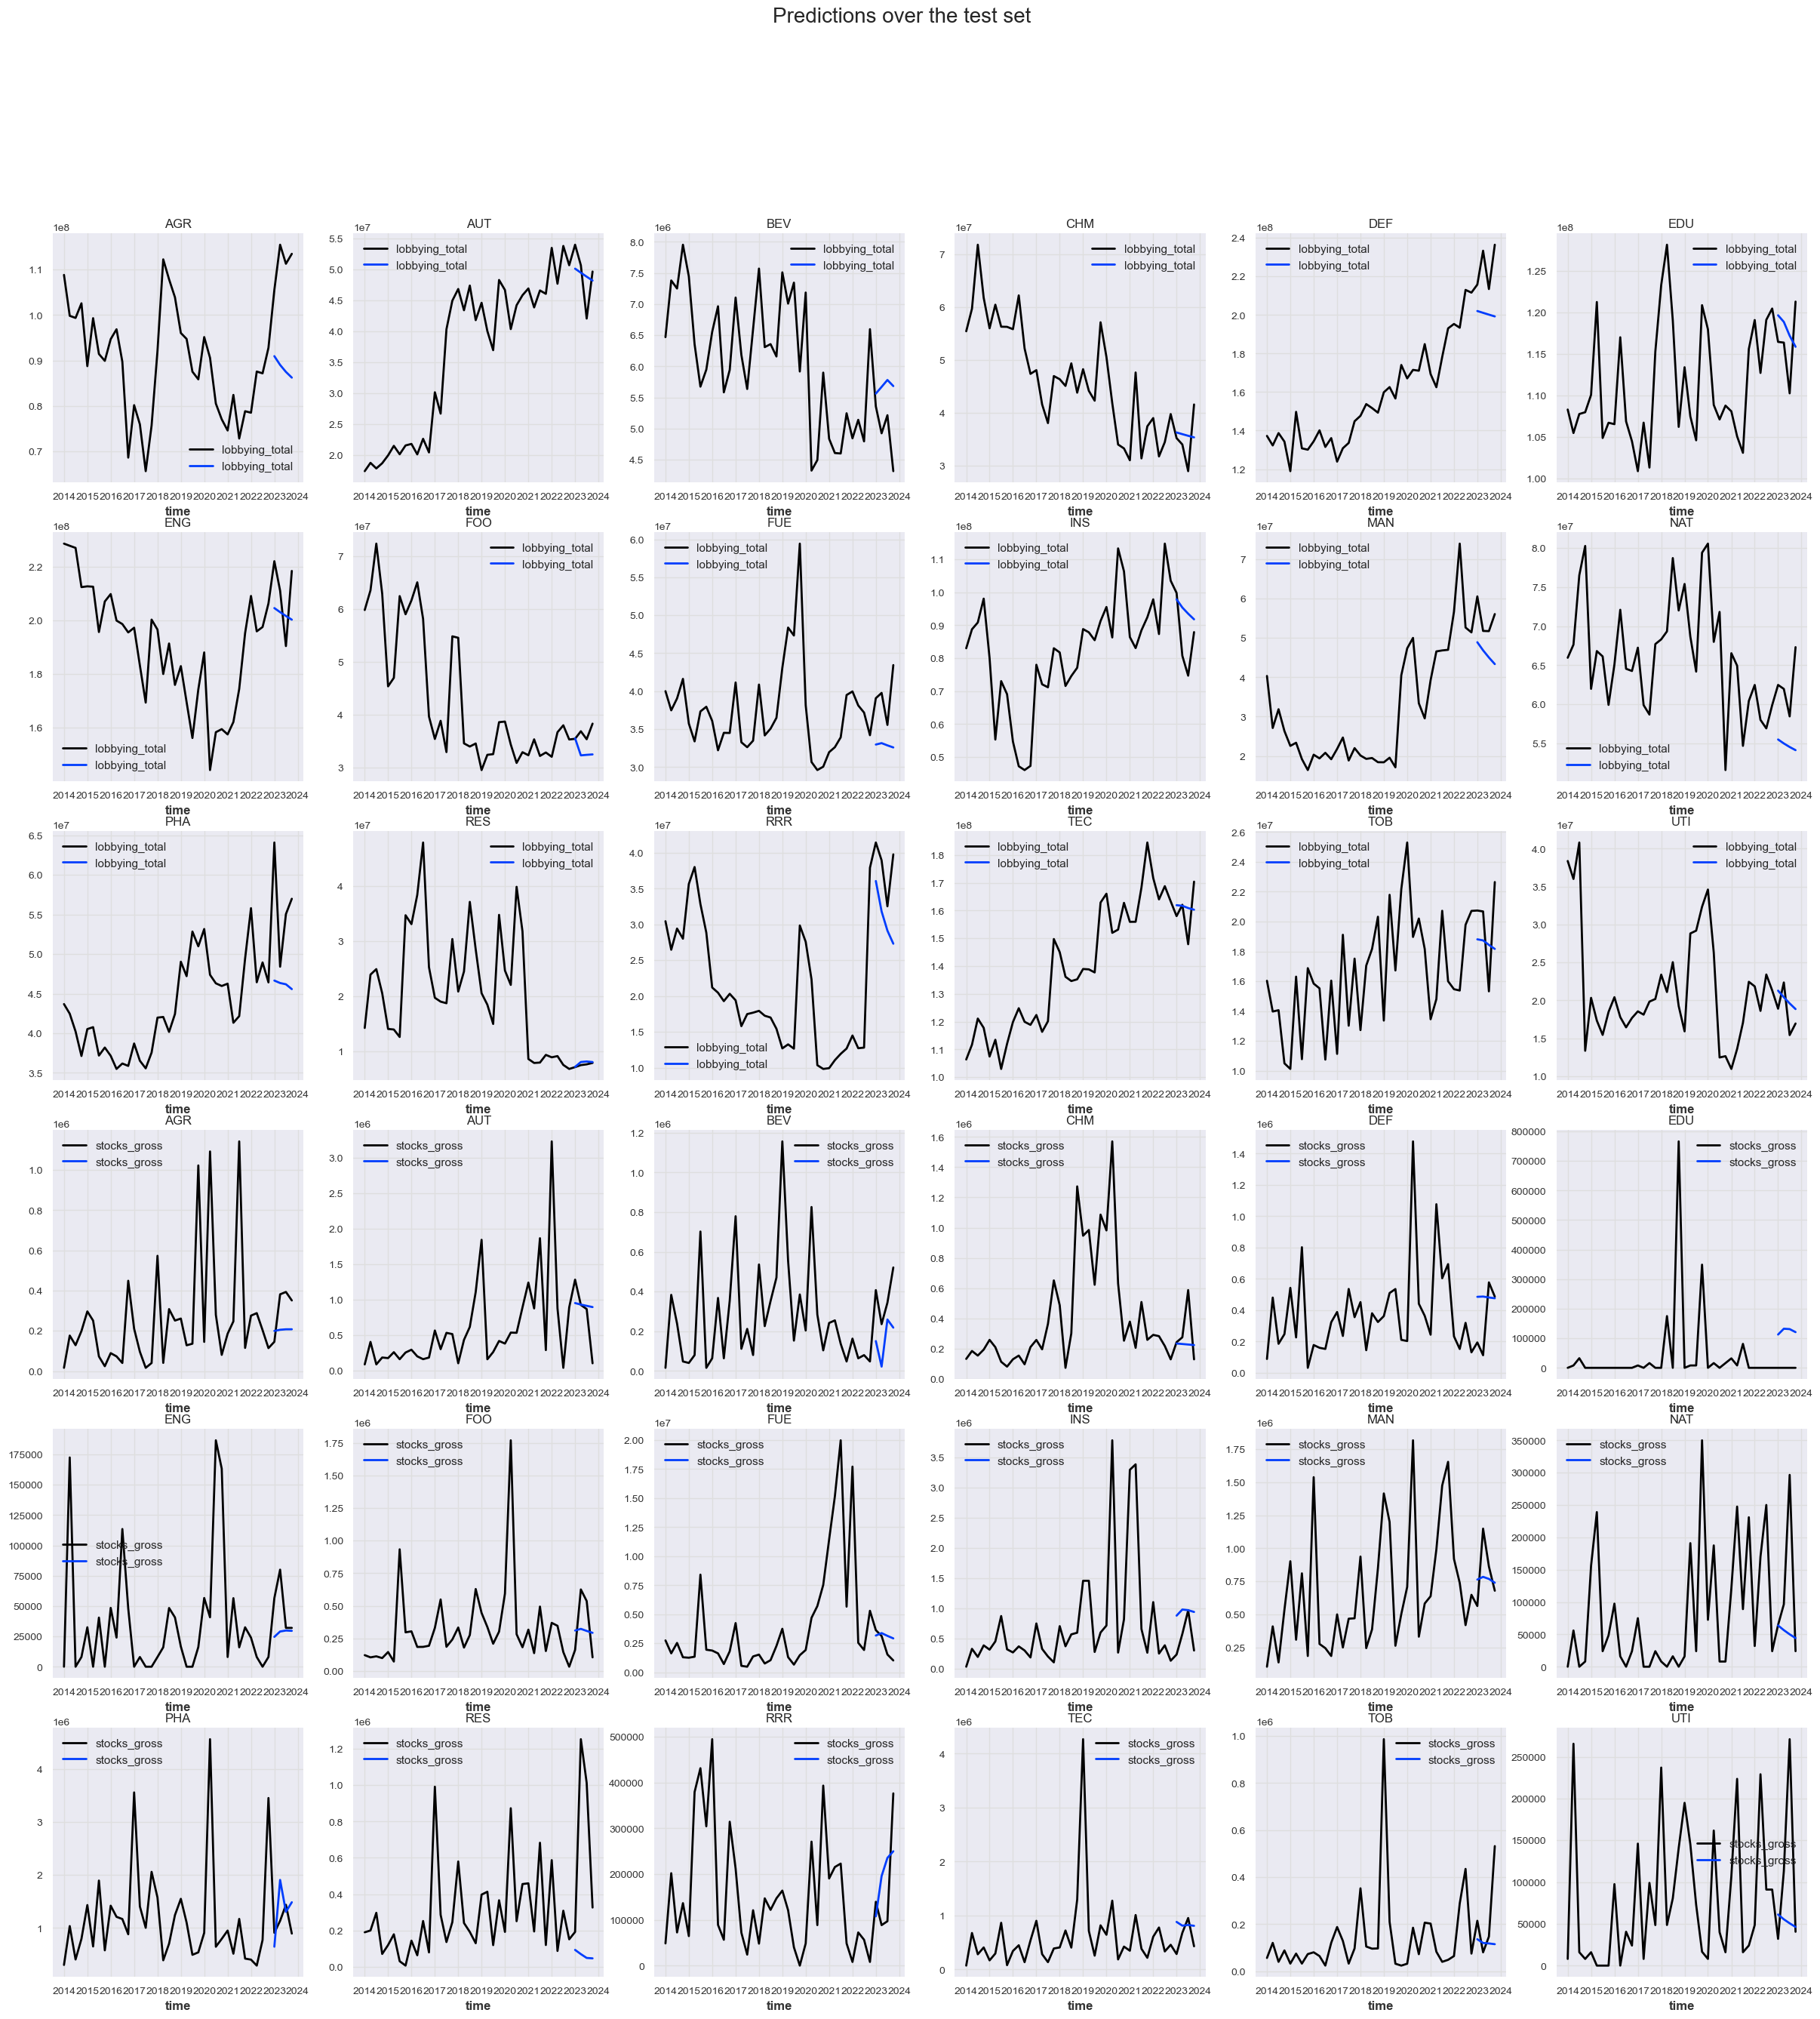

In [16]:
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
test_performance=pd.DataFrame()

fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs=axs.flatten()
fig.suptitle('Predictions over the test set', size=20)
for i, code in enumerate(cognates.keys()):
    model=VARIMA(joint_model_params[code][0][0], joint_model_params[code][0][1], joint_model_params[code][0][2])
    pred, actual = predict(issue_code=code, model=model)
    actual['lobbying_total'].plot(ax= axs[i])
    pred['lobbying_total'].plot(ax= axs[i])
    axs[i].set_title(code)
    actual['stocks_gross'].plot(ax= axs[i+18])
    pred['stocks_gross'].plot(ax= axs[i+18])
    axs[i+18].set_title(code)
    code_performance=[msse(actual[variable][-4:], pred[variable], actual[variable][:-4], m=1) for variable in lobb_vars+stocks_vars] #msse with 1-seasonality
    test_performance[code]=code_performance
test_performance.index=lobb_vars+stocks_vars
display(test_performance)

In [36]:
test_performance.sum(axis=1)

lobbying_total    35.536820
stocks_gross      11.761403
dtype: float64

#### A place for nice plots and figures

In [22]:
from darts.utils.statistics import check_seasonality
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

Text(0, 0.5, 'Lobbying (USD)')

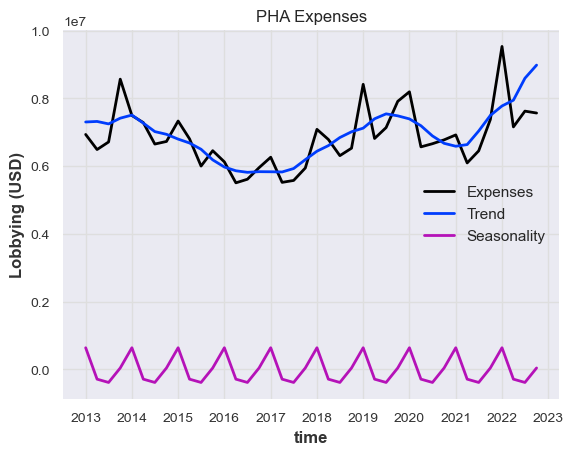

In [23]:
issue=stock_and_lobbying_totals('PHA', cognates['PHA'], adjust_for_num_codes=True)
expenses=TimeSeries.from_dataframe(issue)['lobbying_expenses']
trend, seasonality = extract_trend_and_seasonality(expenses, model=ModelMode.ADDITIVE, freq=4)
fig, axs =plt.subplots(1,1)
expenses.plot(label='Expenses', ax=axs)
trend.plot(label='Trend', ax=axs)
seasonality.plot(label='Seasonality', ax=axs)
axs.set_title('PHA Expenses')
axs.set_ylabel('Lobbying (USD)')

Text(0, 0.5, 'Lobbying (USD)')

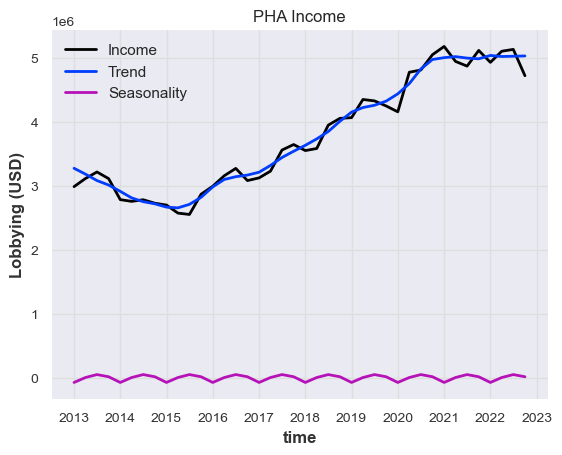

In [25]:
issue=stock_and_lobbying_totals('PHA', cognates['PHA'], adjust_for_num_codes=True)
income=TimeSeries.from_dataframe(issue)['lobbying_income']
trend, seasonality = extract_trend_and_seasonality(income, model=ModelMode.ADDITIVE, freq=4)
fig, axs =plt.subplots(1,1)
income.plot(label='Income', ax=axs)
trend.plot(label='Trend', ax=axs)
seasonality.plot(label='Seasonality', ax=axs)
axs.set_title('PHA Income')
axs.set_ylabel('Lobbying (USD)')

<Axes: ylabel='stocks_gross'>

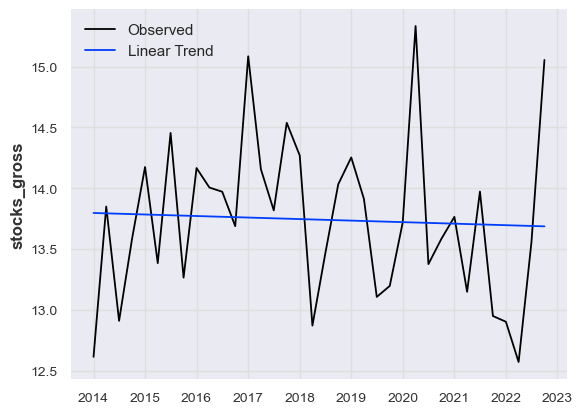

In [35]:
industry_totals = stock_totals(cognates['PHA'])
    # Exclude early dates for which there's no data
industry_totals = industry_totals[industry_totals.index > pd.to_datetime("2013-12-31")]
x = np.log1p(industry_totals["stocks_gross"])
n = len(x)
lin_inputs = np.vstack([np.ones(n), np.arange(n)]).T
lin_trend = LinearRegression().fit(X=lin_inputs,y=x)
x_pred=lin_trend.predict(X=lin_inputs)
fig= plt.figure()
sns.lineplot(x, label="Observed")
sns.lineplot(pd.Series(x_pred, index=x.index), label="Linear Trend")